In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import QuantileTransformer, PowerTransformer

from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

from importlib import reload

import warnings
warnings.filterwarnings("ignore")

import wrangle
import explore as ex
sns.set(rc={'figure.facecolor':'fbf3e4','axes.facecolor':'fbf3e4'})
#sns.set(font_scale=1.5)
pd.options.display.float_format = '{:,.3f}'.format

In [2]:
reload(wrangle)

<module 'wrangle' from '/Users/garrettarnett/codeup-data-science/zillow-project/wrangle.py'>

In [3]:
zillow = wrangle.get_zillow()

In [4]:
zillow.shape

(50157, 9)

In [5]:
zillow.describe()

,bedrooms,bathrooms,sq_feet,lot_sqft,year_built,house_age,pools,home_value
count,"50,157.000","50,157.000","50,157.000","50,157.000","50,157.000","50,157.000","50,157.000","50,157.000"
mean,3.270,2.162,"1,832.414","10,670.496","1,962.912",54.088,0.201,"441,682.317"
std,0.886,0.862,795.766,"86,738.718",22.648,22.648,0.401,"350,433.125"
min,1.000,1.000,300.000,236.000,"1,878.000",1.000,0.000,"1,000.000"
25%,3.000,2.000,"1,258.000","5,542.000","1,950.000",39.000,0.000,"188,246.000"
50%,3.000,2.000,"1,633.000","6,768.000","1,960.000",57.000,0.000,"362,552.000"
75%,4.000,3.000,"2,229.000","8,552.000","1,978.000",67.000,0.000,"585,547.000"
max,6.000,6.000,"5,478.000","6,971,010.000","2,016.000",139.000,1.000,"1,997,251.000"


In [6]:
zillow.isnull().sum()


bedrooms       0
bathrooms      0
sq_feet        0
lot_sqft       0
year_built     0
house_age      0
pools          0
county_name    0
home_value     0
dtype: int64

In [7]:
train, validate, test = wrangle.split_zillow(zillow)

In [8]:
train.shape

(28087, 9)

In [9]:
validate.shape

(12038, 9)

In [10]:
test.shape

(10032, 9)

## Explore

In [11]:
train.head()

,bedrooms,bathrooms,sq_feet,lot_sqft,year_built,house_age,pools,county_name,home_value
6510,4,2,1815,7280,1927,90,0,LA,455634
17386,2,2,1330,3970,1925,92,0,LA,1325256
25876,2,1,865,6682,1949,68,0,LA,61256
26867,3,2,1387,4985,1979,38,0,LA,530000
5458,4,2,2741,10890,1980,37,0,Ventura,271236


In [12]:
cat_vars = ['bedrooms', 'bathrooms', 'county_name']
cont_vars = ['sq_feet', 'lot_sqft', 'home_value', 'house_age']
palettes = ['flare', 'Blues_r', 'PuRd_r', 'Accent']
colors_sns = sns.color_palette("flare")
colors_sns2 = sns.color_palette("Blues_r")

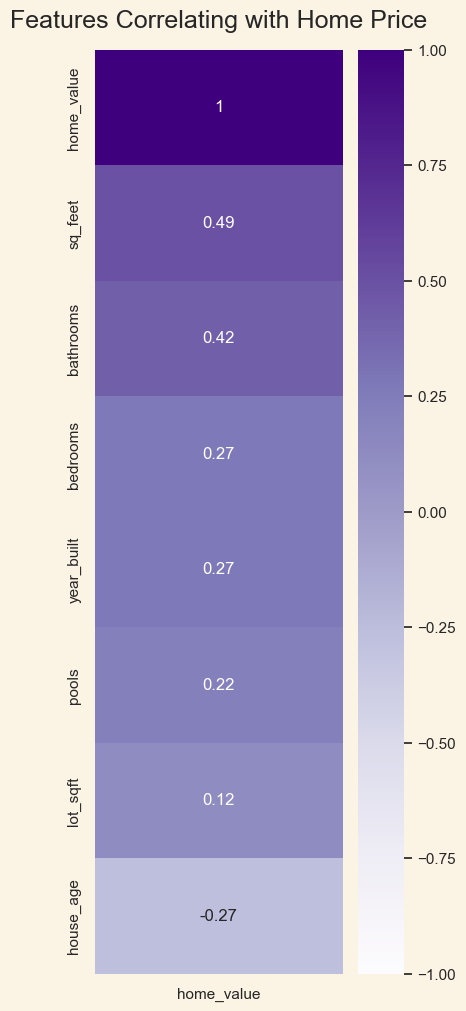

In [13]:

plt.figure(figsize=(4, 12))
heatmap = sns.heatmap(train.corr(method='spearman')[['home_value']].sort_values(by='home_value', ascending=False), vmin=-1, vmax=1, annot=True, cmap='Purples')
heatmap.set_title('Features Correlating with Home Price', fontdict={'fontsize':18}, pad=16);

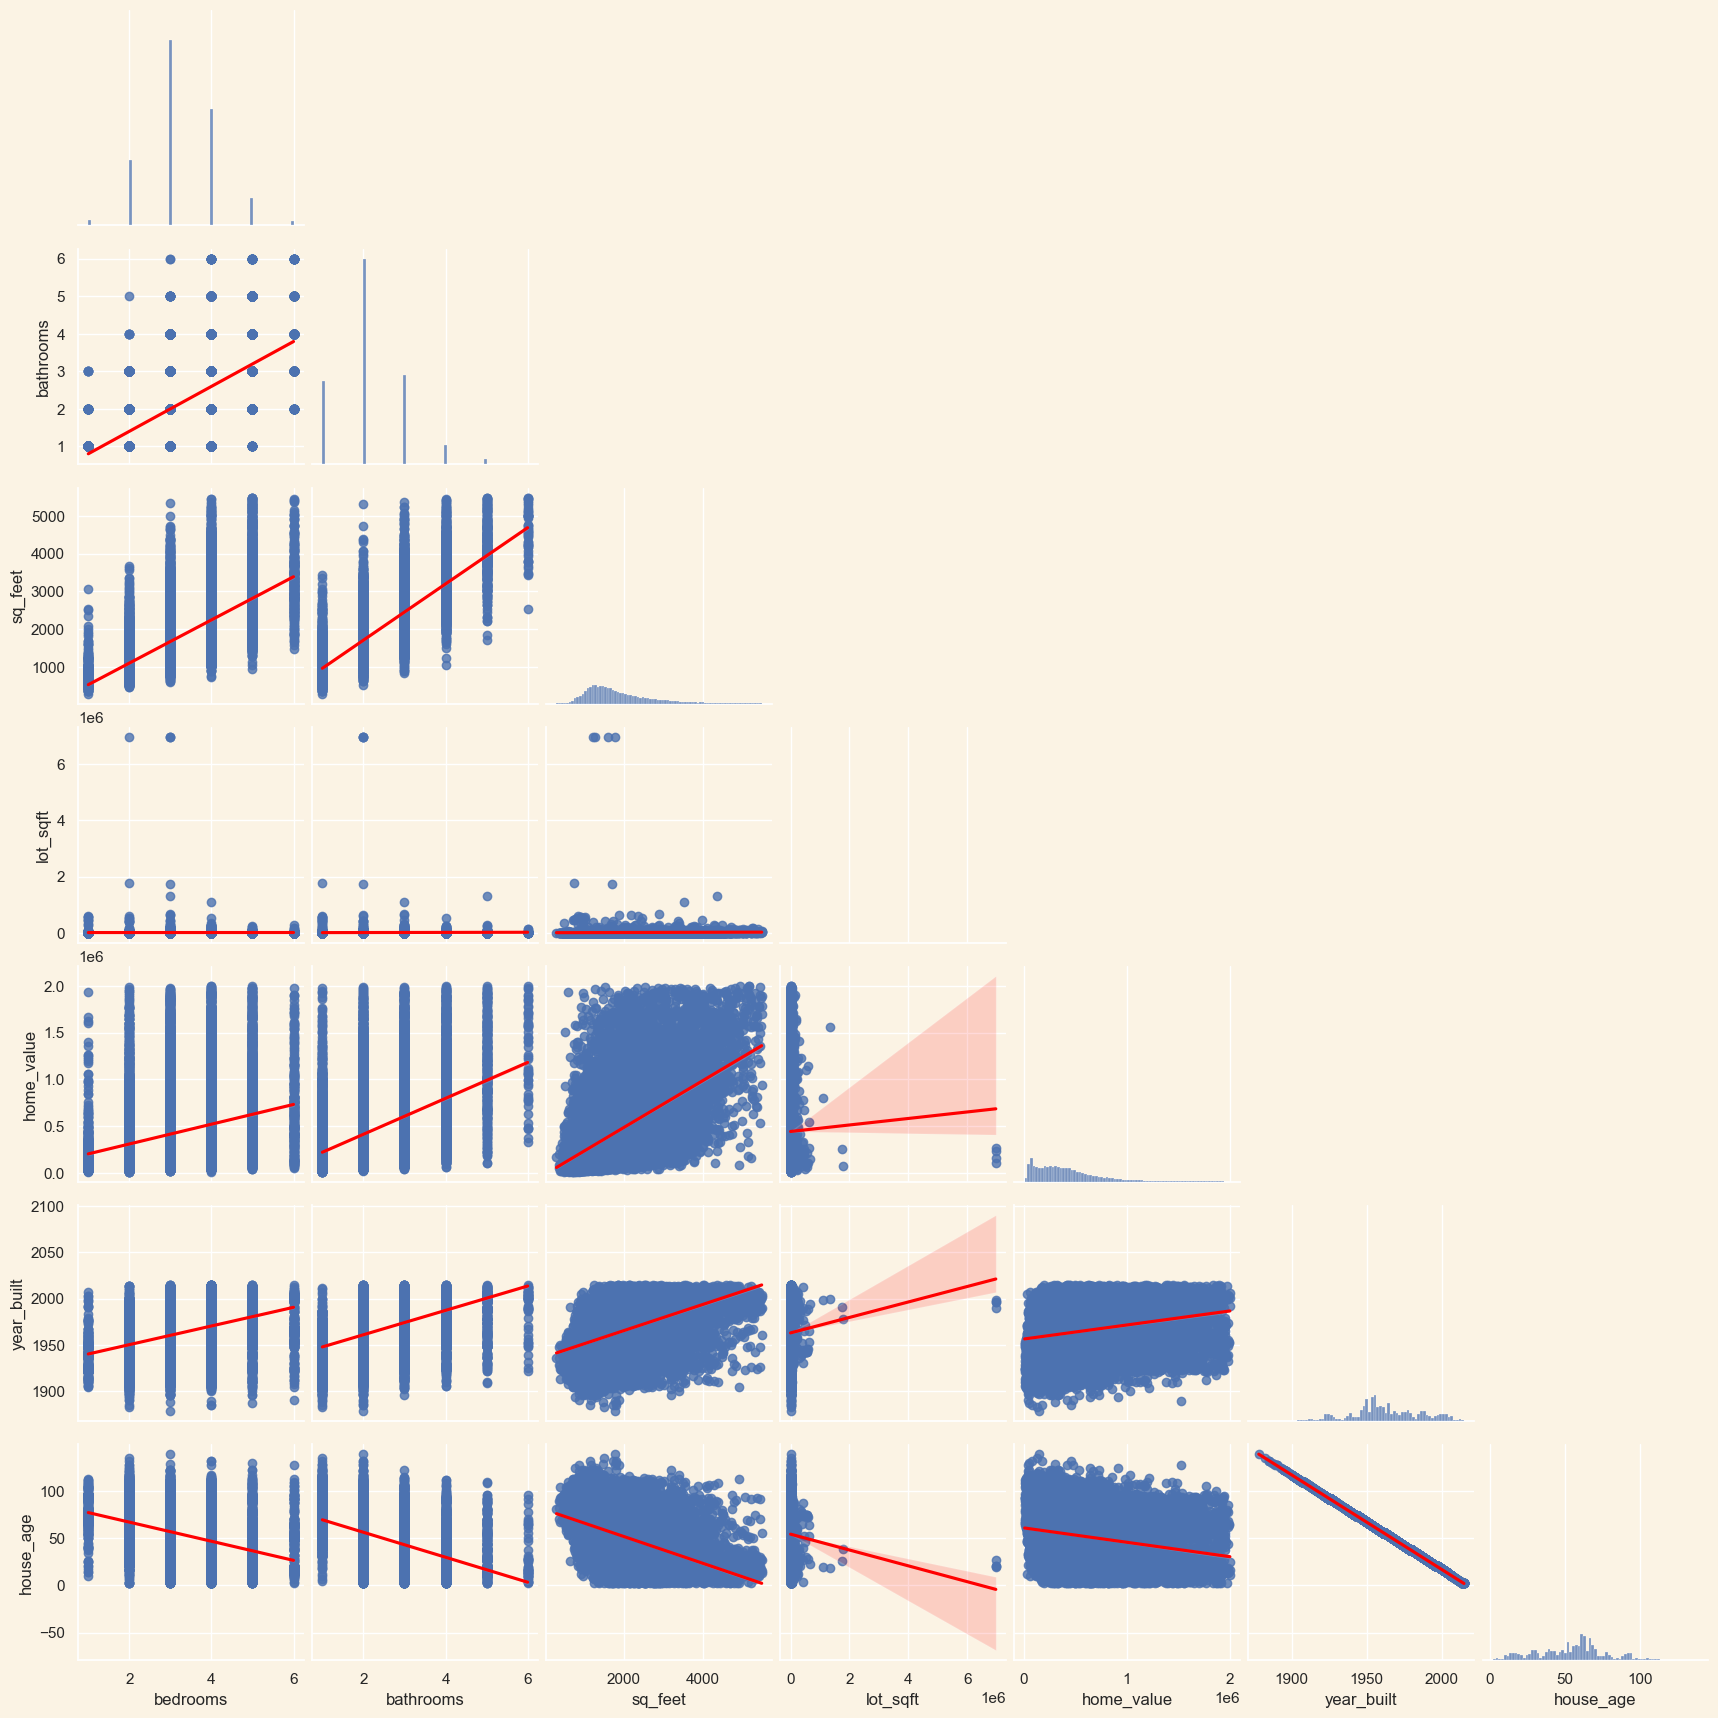

In [21]:
ex.pairplot_data(train)

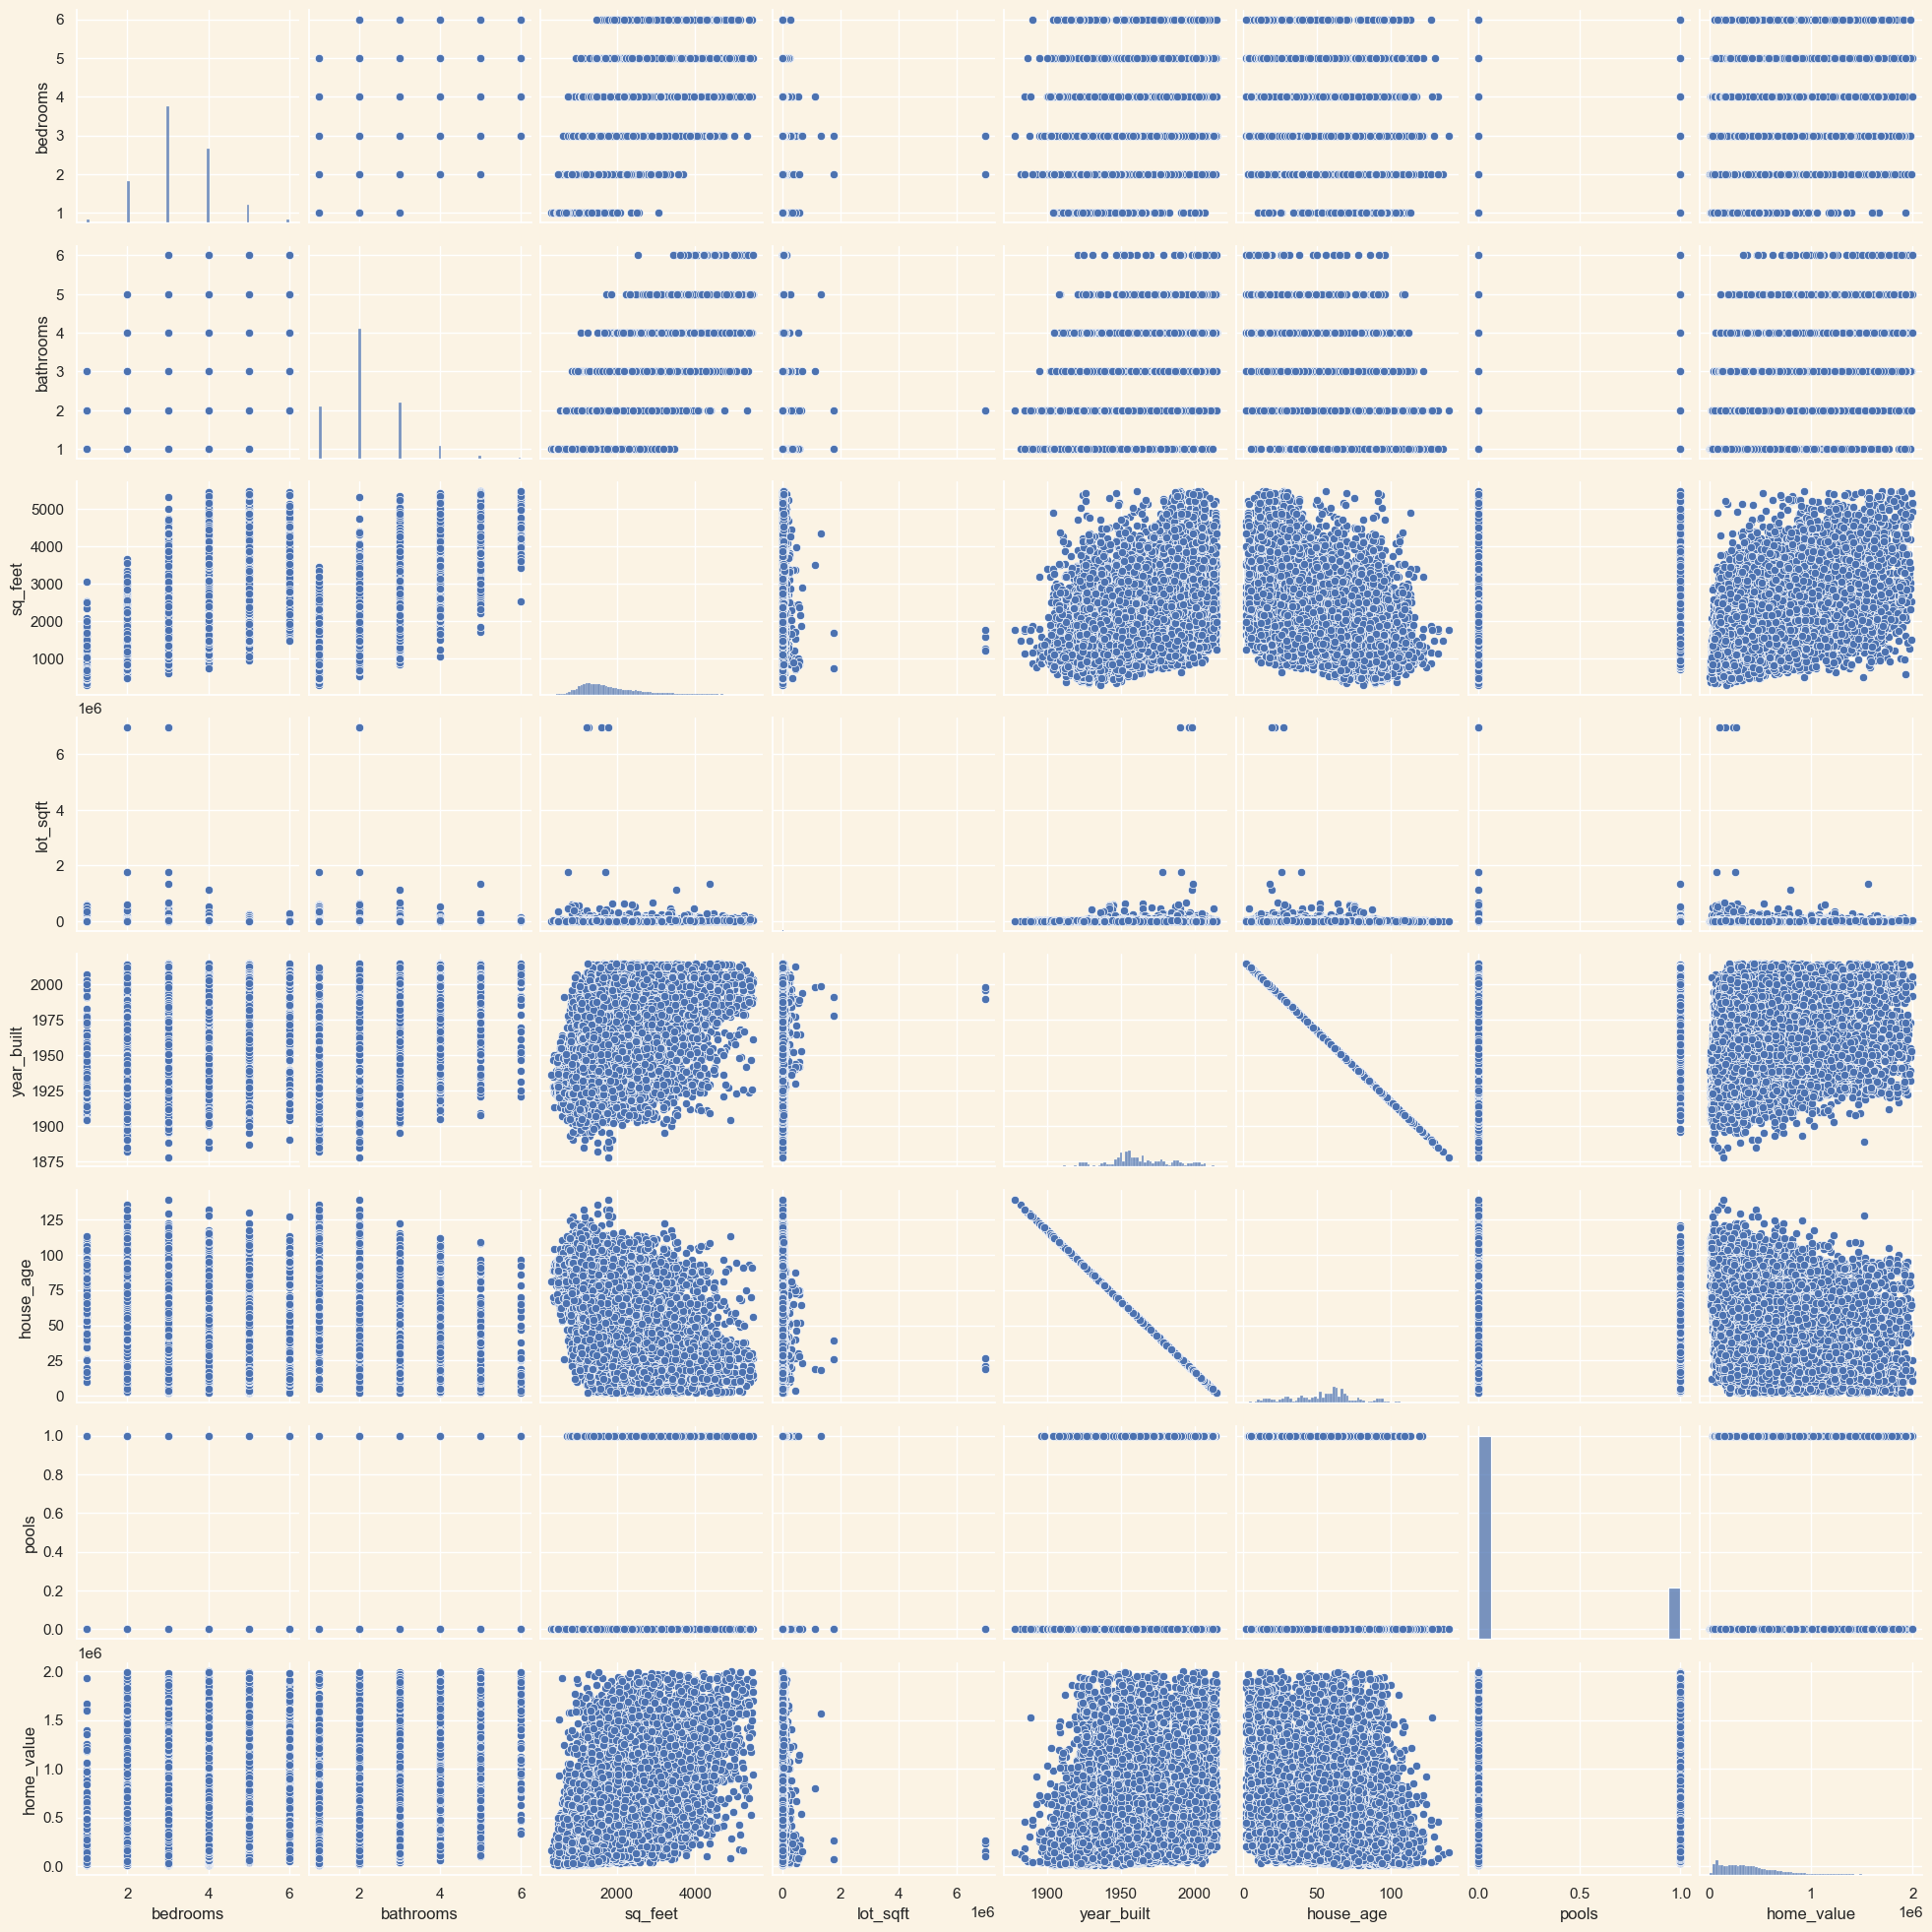

In [14]:
sns.pairplot(train)

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28087 entries, 6510 to 17544
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   bedrooms     28087 non-null  uint8   
 1   bathrooms    28087 non-null  uint8   
 2   sq_feet      28087 non-null  int64   
 3   lot_sqft     28087 non-null  int64   
 4   year_built   28087 non-null  int64   
 5   house_age    28087 non-null  uint8   
 6   pools        28087 non-null  uint8   
 7   county_name  28087 non-null  category
 8   home_value   28087 non-null  int64   
dtypes: category(1), int64(4), uint8(4)
memory usage: 2.2 MB


In [16]:
log_lot = np.log(train.lot_sqft)

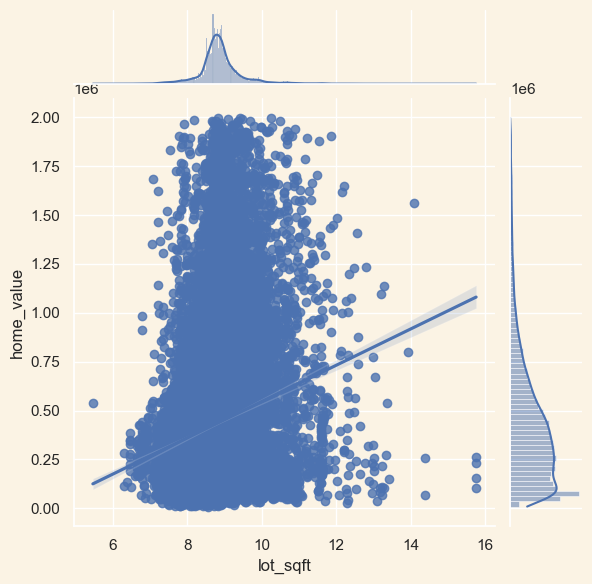

In [17]:
sns.jointplot(x=log_lot, y=train.home_value, kind='reg')

In [18]:
def show_cont_vars(df):
    '''
    this function accepts a zillow data sample and the list
    of continuous column names
    builds boxplots for every column from the list
    '''
    #sample = df.sample(100_000, random_state=2912)
    print('Continuous Variables:')
    plt.figure(figsize=(20, 4))
    for i, col in enumerate(cont_vars):
        plt.subplot(1, 4, i+1)
        plt.title(col)
        sns.boxplot(x=col, data=df, color=colors_sns2[i])

Continuous Variables:


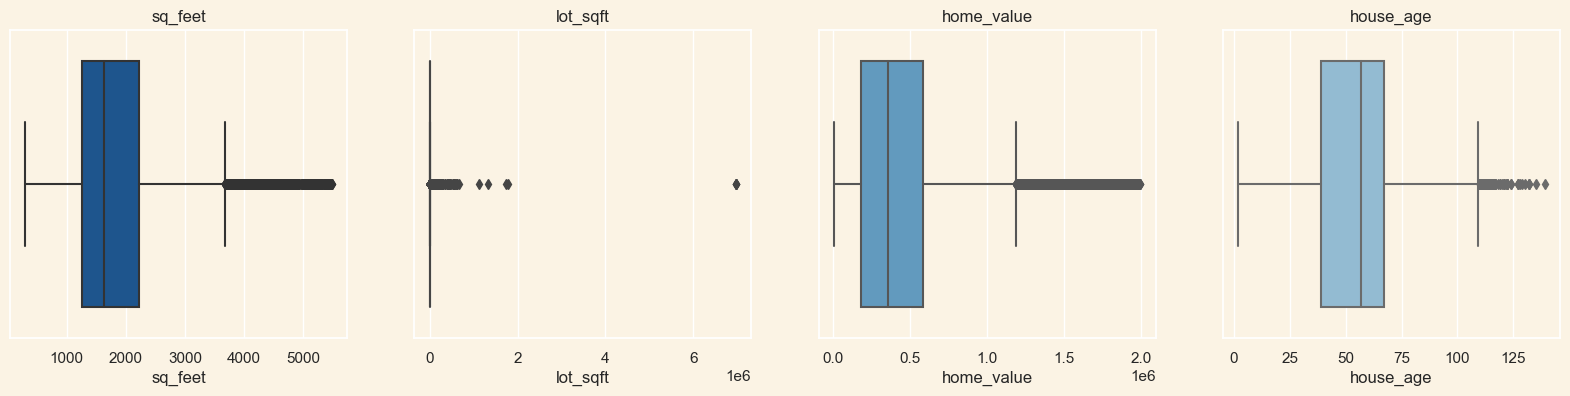

In [19]:
show_cont_vars(train)

Categorical Variables:


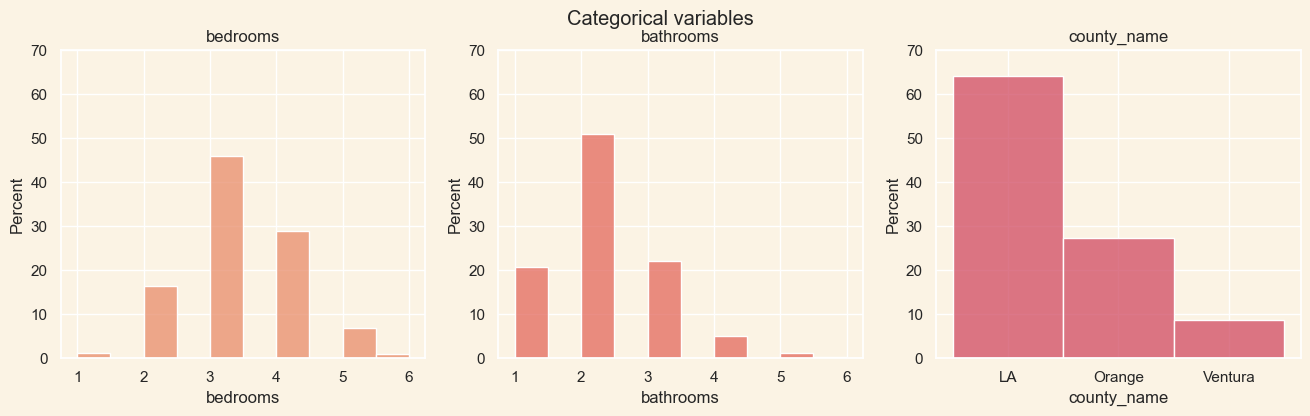

In [20]:
ex.show_categ_vars(train)

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [23]:
def vif(df):
    vif_data = pd.DataFrame()
    vif_data['features'] = df.drop(columns='county_name').columns
    vif_data['VIF'] = [variance_inflation_factor(df.drop(columns='county_name').\
                                                 values, i) for i in range(len(df.columns)-1)]
    display(vif_data.sort_values(by='VIF', ascending=False))

In [24]:
vif(train)

,features,VIF
4,year_built,34.727
5,house_age,8.661
2,sq_feet,3.875
1,bathrooms,3.100
0,bedrooms,1.833
7,home_value,1.524
6,pools,1.143
3,lot_sqft,1.002


## 1. Do the home prices vary in three different counties?


In [25]:
train.describe()

,bedrooms,bathrooms,sq_feet,lot_sqft,year_built,house_age,pools,home_value
count,"28,087.000","28,087.000","28,087.000","28,087.000","28,087.000","28,087.000","28,087.000","28,087.000"
mean,3.268,2.158,"1,831.306","10,707.811","1,962.848",54.152,0.202,"442,349.265"
std,0.887,0.860,794.480,"87,180.761",22.634,22.634,0.401,"352,343.397"
min,1.000,1.000,300.000,236.000,"1,878.000",2.000,0.000,"9,242.000"
25%,3.000,2.000,"1,257.000","5,537.500","1,950.000",39.000,0.000,"187,318.000"
50%,3.000,2.000,"1,634.000","6,767.000","1,960.000",57.000,0.000,"361,337.000"
75%,4.000,3.000,"2,225.500","8,537.000","1,978.000",67.000,0.000,"588,844.000"
max,6.000,6.000,"5,477.000","6,971,010.000","2,015.000",139.000,1.000,"1,997,251.000"


In [26]:
def price_distribution(df):
    plt.figure(figsize = (10, 6), facecolor='#fbf3e4')
    plt.suptitle('Home price distribution in the data set', fontsize = 20)
    bins = np.arange(0, 2_500_500, 100_000).astype(int)
    ax = sns.histplot(data=df, x = 'home_value',stat='percent', bins=bins,  kde=True)
    plt.vlines(df.home_value.mean(), 0, 12, color=(0.82, 0.29, 0.38), label='mean price')
    plt.vlines(df.home_value.median(), 0, 14, color='blue', label='median price')
    plt.xlabel('Price till $2.5 Million', fontsize=16)
    plt.ylabel('Percentage', fontsize=16)
    plt.text(1_500_500, 6, 'each bin = $ 100,000')
    plt.text(1_500_500, 9, f'mean - median = {round(df.home_value.mean() - df.home_value.median(), 2)}')
    plt.legend()

    plt.show()

In [29]:
df=wrangle.get_zillow()

In [30]:
train, validate, test = wrangle.split_zillow(df)

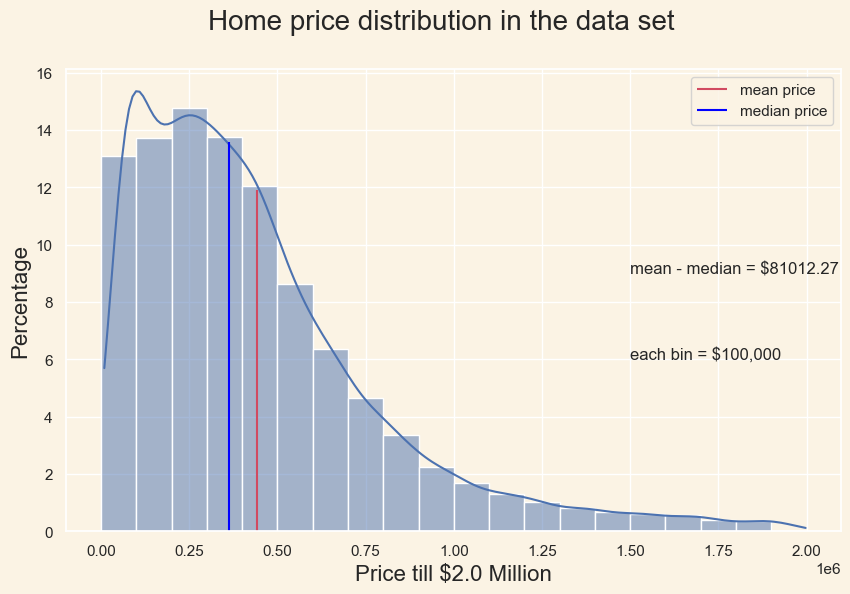

In [31]:
plt.figure(figsize = (10, 6), facecolor='#fbf3e4')
plt.suptitle('Home price distribution in the data set', fontsize = 20)
bins = np.arange(0, 2_000_000, 100_000).astype(int)
ax = sns.histplot(data=train, x = 'home_value',stat='percent', bins=bins,  kde=True)
plt.vlines(train.home_value.mean(), 0, 11.9, color=(0.82, 0.29, 0.38), label='mean price')
plt.vlines(train.home_value.median(), 0, 13.6, color='blue', label='median price')
plt.xlabel('Price till $2.0 Million', fontsize=16)
plt.ylabel('Percentage', fontsize=16)
plt.text(1_500_500, 6, 'each bin = $100,000')
plt.text(1_500_500, 9, f'mean - median = ${round(train.home_value.mean() - train.home_value.median(), 2)}')
plt.legend()

plt.show()

In [32]:
def viz_counties(df):
    plt.figure(figsize=(18, 6))

    plt.suptitle('Home prices in different counties', fontsize=20)
    plt.subplot(121)
    graph = sns.barplot(x='county_name', y='home_value', estimator=np.median, data=df, palette='flare')
    graph.axhline(df.home_value.median(), color = (0.4, 0.4, 0.4), label = 'median')
    plt.title('Median', fontsize=16)
    plt.ylim(0, 550_000)
    plt.legend()

    plt.subplot(122)
    graph = sns.barplot(x='county_name', y='home_value', data=df, palette='Accent')
    graph.axhline(df.home_value.median(), color = (0.4, 0.4, 0.4), label = 'mean')
    plt.title('Mean', fontsize=16)
    plt.ylim(0, 550_000)
    plt.legend()

    plt.show()

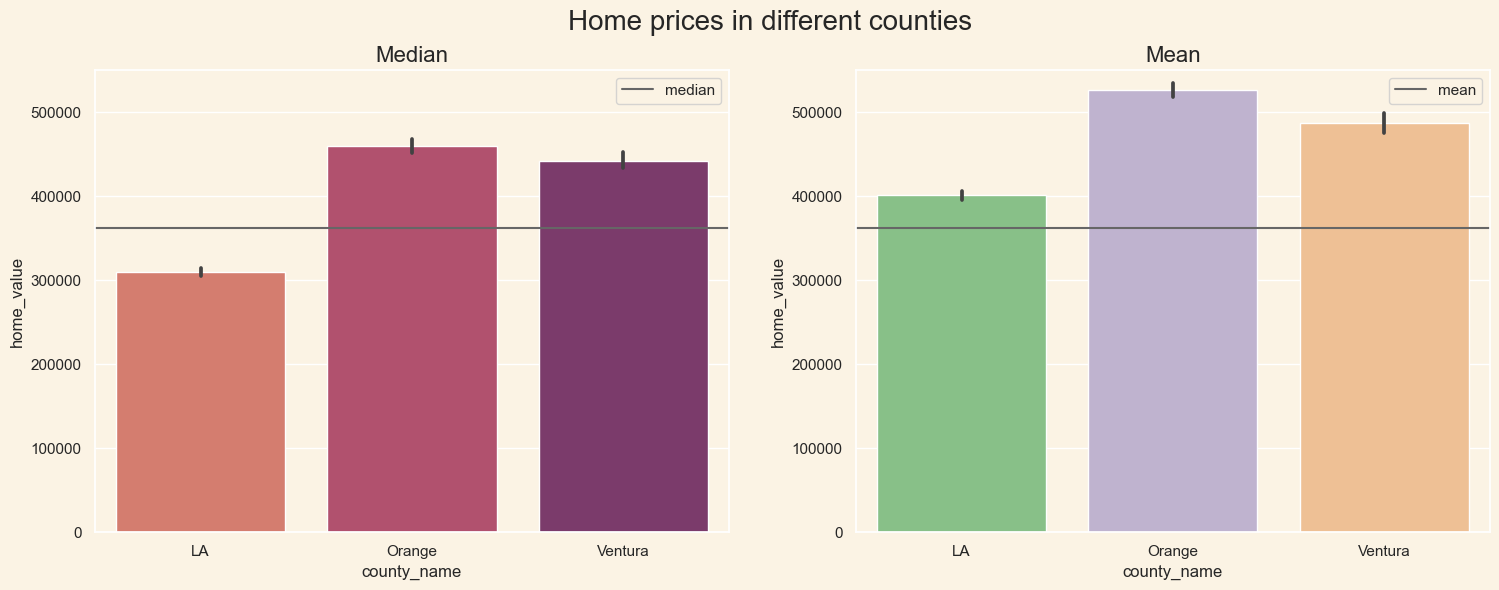

In [33]:
viz_counties(train)

$H_0$: There is no significant difference between home_value in different county_name counties.
    
$H_a$: There is a significant difference between home_value in different county_name counties.

In [35]:
la = train[train.county_name == 'LA'] # LA county
ventura = train[train.county_name == 'Ventura'] # Ventura county
orange = train[train.county_name == 'Orange'] # Orange county

In [36]:
la.shape, ventura.shape, orange.shape

((18030, 9), (2424, 9), (7633, 9))

In [37]:
alpha = 0.05
p = stats.levene(la.home_value, orange.home_value, ventura.home_value)[1]
if (p < alpha):
    print('Variances are different. Use an non-parametric test.')
else:
    print('Variances are equal. Use a parametric test')

Variances are different. Use an non-parametric test.


In [38]:
p_kr = stats.kruskal(la.home_value, orange.home_value, ventura.home_value)[1]
if (p_kr < alpha):
    print('We reject the null hypothesis.')
    print('There is a significant difference in home prices in different counties.')
else:
    print('We fail to reject the null hypothesis.')
    print('There is no significant difference in home prices in different counties.')

We reject the null hypothesis.
There is a significant difference in home prices in different counties.


In [40]:
def test_counties(df):
    '''
    the function accepts a zillow data set as a parameter, splits it into 3 data sets
    where each represents separate county
    run the Levene tests to check the assumptions and runs the Kruskal-Wallis stat test
    that compares means of the samples
    '''
    # create 3 data sets that keep the values of the counties
    la = df[train.county_name == 'LA'] # LA county
    ventura = df[train.county_name == 'Ventura'] # Ventura county
    orange = df[train.county_name == 'Orange'] # Orange county
    
    # Levene test
    p = stats.levene(la.home_value, orange.home_value, ventura.home_value)[1]
    if (p < alpha):
        print('Variances are different. Use an non-parametric Kruskal-Wallis test.')
    else:
        print('Variances are equal. Use a parametric ANOVA test')
    
    print()
    
    # Kruskal-Wallis test
    p_kr = stats.kruskal(la.home_value, orange.home_value, ventura.home_value)[1]
    if (p_kr < alpha):
        print('We reject the null hypothesis.')
        print('There is a significant difference in home prices in different counties.')
    else:
        print('We fail to reject the null hypothesis.')
        print('There is no significant difference in home prices in different counties.')

In [41]:
test_counties(train)

Variances are different. Use an non-parametric Kruskal-Wallis test.

We reject the null hypothesis.
There is a significant difference in home prices in different counties.


## 2. Do houses with pools cost more than the houses without pool?

In [42]:
def pools_viz(df):
    '''
    the function accepts a zillow data frame as a parameter and creates 2 plots
    that show a difference between houses with pools and without pools
    '''
    plt.figure(figsize=(18, 6), facecolor='#fbf3e4')

    plt.suptitle('Prices for homes with and without pool', fontsize=20)
    
    # subplot 1 houses with pool prices in different counties
    plt.subplot(121)
    graph = sns.barplot(x='pools', y='home_value', estimator=np.median, hue='county_name', data=df, palette='flare')
    graph.axhline(df.home_value.median(), label='median price')
    plt.title('Prices in different counties', fontsize=16)
    plt.ylim(0, 700_000)
    plt.legend()

    # subplot 2 houses with pool prices in the data set
    plt.subplot(122)
    graph = sns.barplot(x='pools', y='home_value', data=df, estimator=np.median, palette='Accent')
    graph.axhline(df.home_value.median(), label='median price')
    plt.ylim(0, 700_000)
    plt.title('Overall prices', fontsize=16)
    plt.legend()

    plt.show()

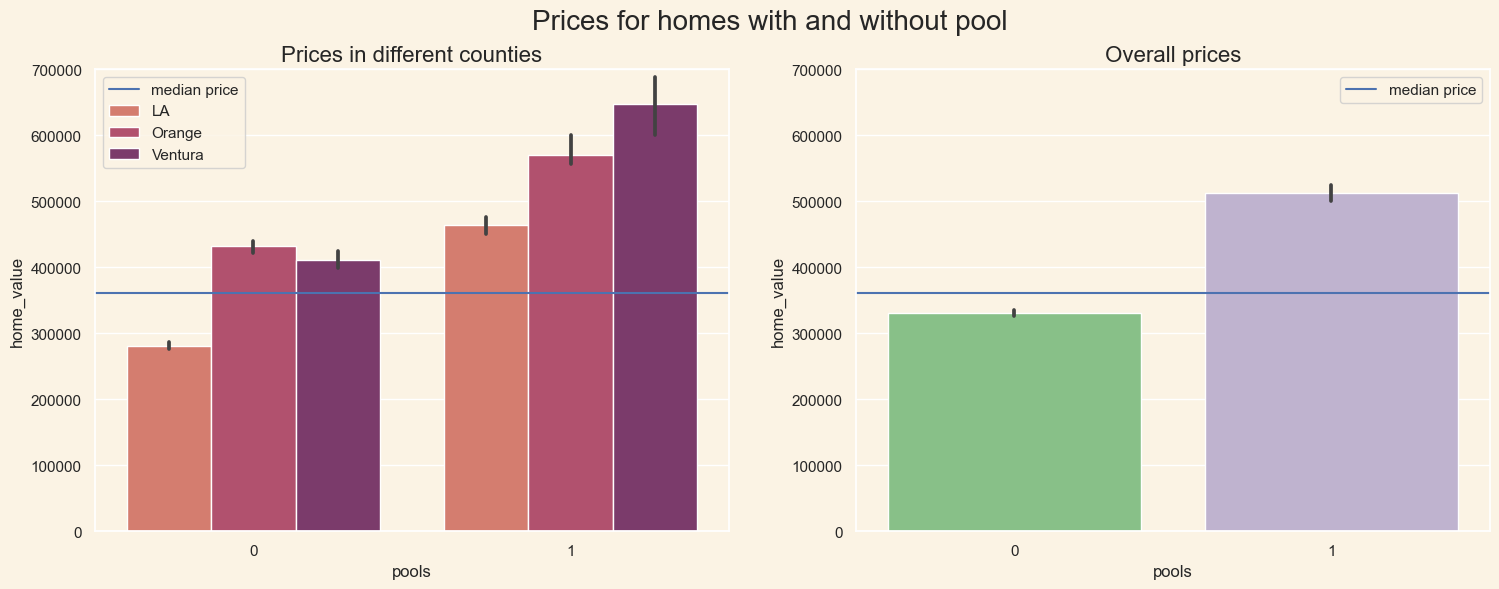

In [43]:
plt.figure(figsize=(18, 6), facecolor='#fbf3e4')

plt.suptitle('Prices for homes with and without pool', fontsize=20)
plt.subplot(121)
graph = sns.barplot(x='pools', y='home_value', estimator=np.median, hue='county_name', data=train, palette='flare')
graph.axhline(train.home_value.median(), label='median price')
plt.title('Prices in different counties', fontsize=16)
plt.ylim(0, 700_000)
plt.legend()

plt.subplot(122)
graph = sns.barplot(x='pools', y='home_value', data=train, estimator=np.median, palette='Accent')
graph.axhline(train.home_value.median(), label='median price')
plt.ylim(0, 700_000)
plt.title('Overall prices', fontsize=16)
plt.legend()

plt.show()

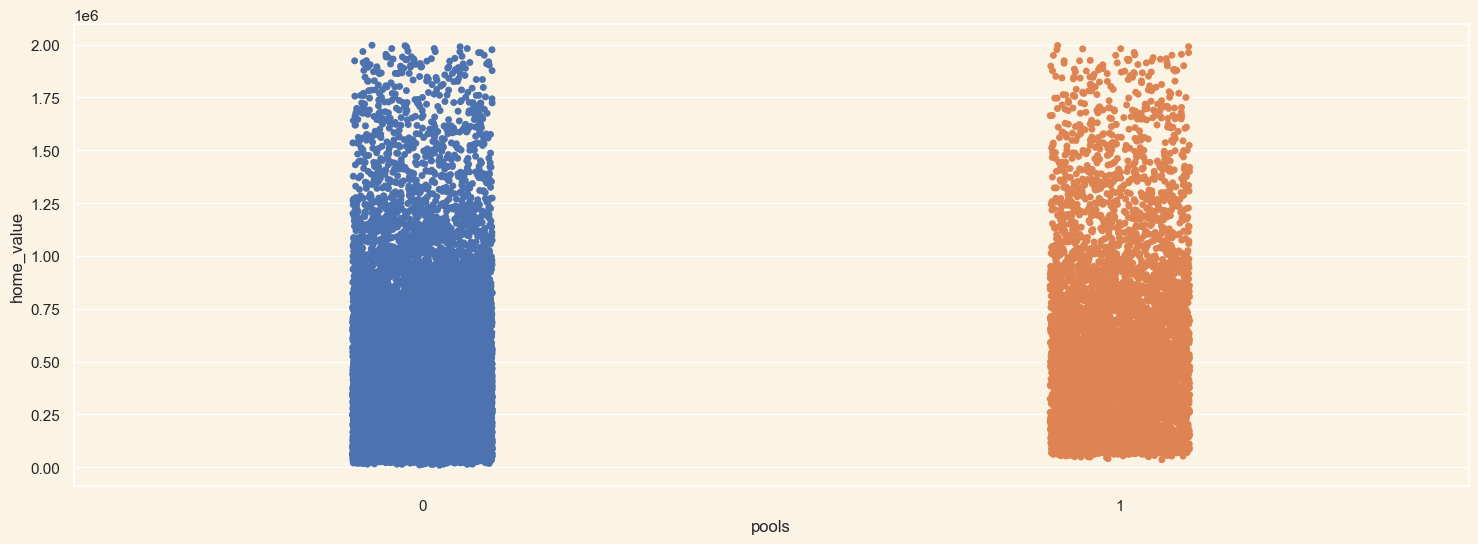

In [44]:
plt.figure(figsize=(18, 6), facecolor='#fbf3e4')
sns.stripplot(x='pools', y='home_value', data=train);

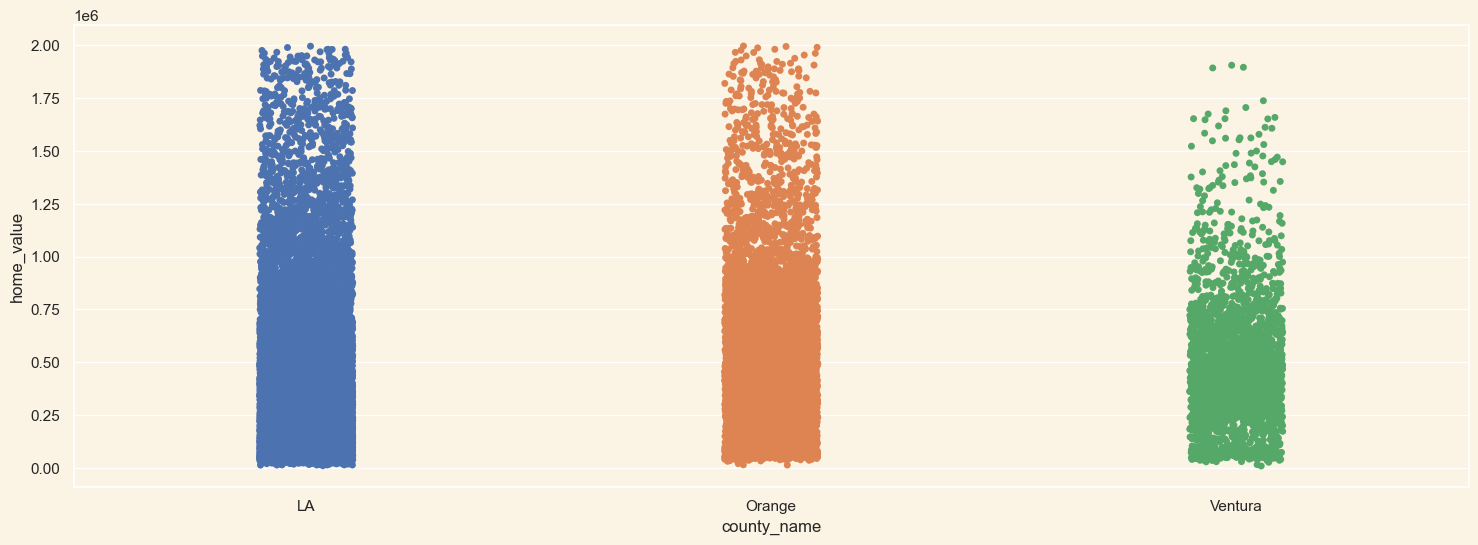

In [45]:
plt.figure(figsize=(18, 6), facecolor='#fbf3e4')
sns.stripplot(x='county_name', y='home_value', data=train);

## 3. Is there a correlation between a square feet of the house and its price?

In [46]:
sns.color_palette('flare')[4] 

(0.56041794, 0.19845221, 0.44207535)

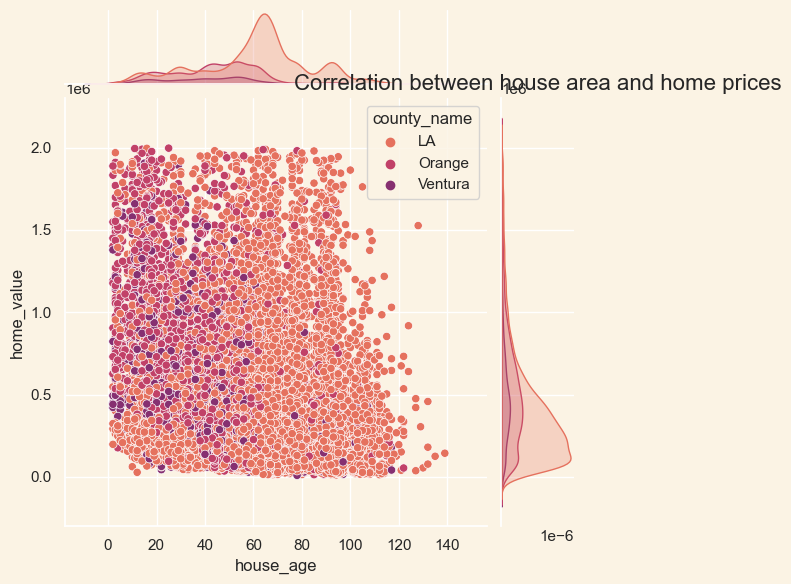

In [47]:
sns.jointplot(x='house_age', y='home_value', data=train, kind='scatter', hue='county_name', palette='flare')
plt.title('Correlation between house area and home prices', fontsize=16);

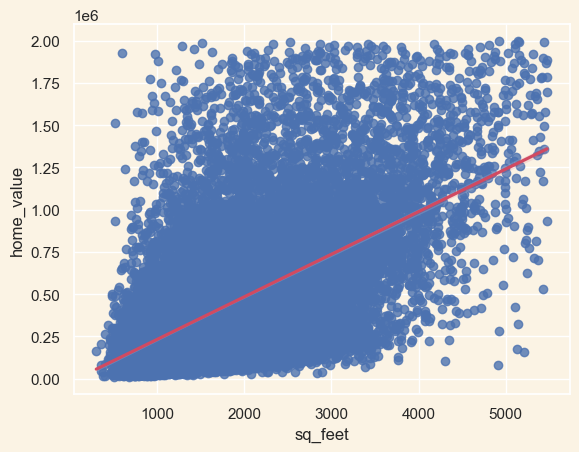

In [48]:
sns.regplot(x='sq_feet', y='home_value', data=train,
             line_kws={'color':(0.819, 0.289, 0.381)});

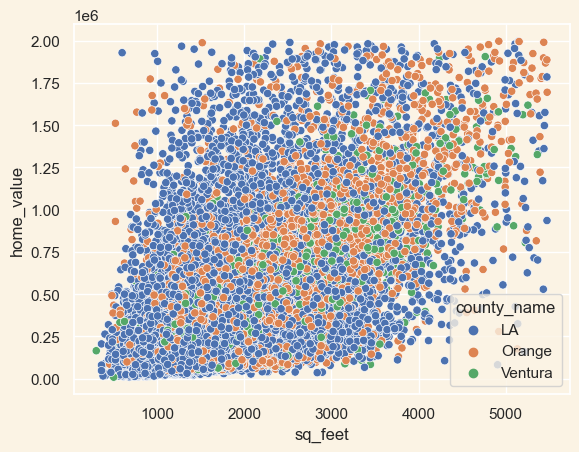

In [49]:
sns.scatterplot(x='sq_feet', y='home_value', data=train, hue='county_name');

In [50]:
def sqft_price_viz(df):
    plt.figure(figsize=(18, 6), facecolor='#fbf3e4')

    plt.suptitle('Correlation between house area and home prices', fontsize=20)

    plt.subplot(121)
    sns.regplot(x='sq_feet', y='home_value', data=df,
                 line_kws={'color':(0.56, 0.198, 0.442)});
    plt.title('With regression line', fontsize=16)

    plt.subplot(122)
    sns.scatterplot(x='sq_feet', y='home_value', data=df, hue='county_name', palette='flare')
    plt.title('With county highlights', fontsize=16)

    plt.show()

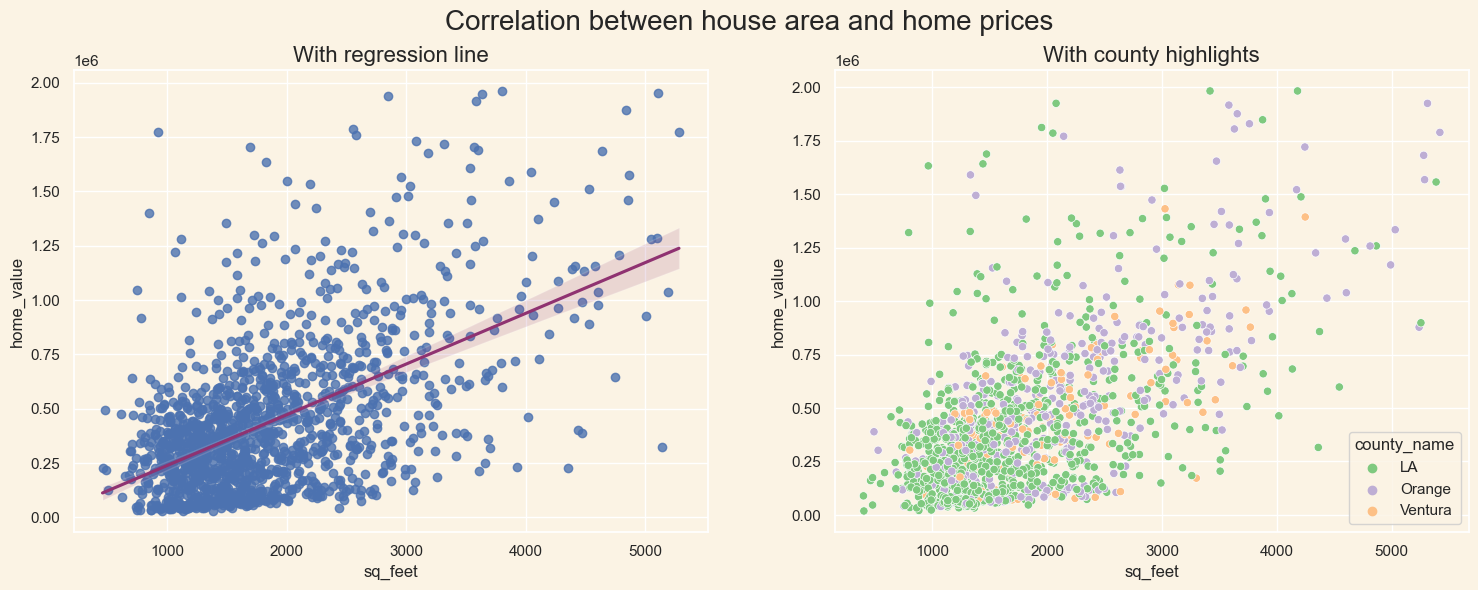

In [51]:
plt.figure(figsize=(18, 6), facecolor='#fbf3e4')

plt.suptitle('Correlation between house area and home prices', fontsize=20)

plt.subplot(121)
sns.regplot(x='sq_feet', y='home_value', data=train.sample(frac=0.05),
             line_kws={'color':(0.56, 0.198, 0.442)});
plt.title('With regression line', fontsize=16)

plt.subplot(122)
sns.scatterplot(x='sq_feet', y='home_value', data=train.sample(frac=0.05), hue='county_name', palette='Accent')
plt.title('With county highlights', fontsize=16)

plt.show()

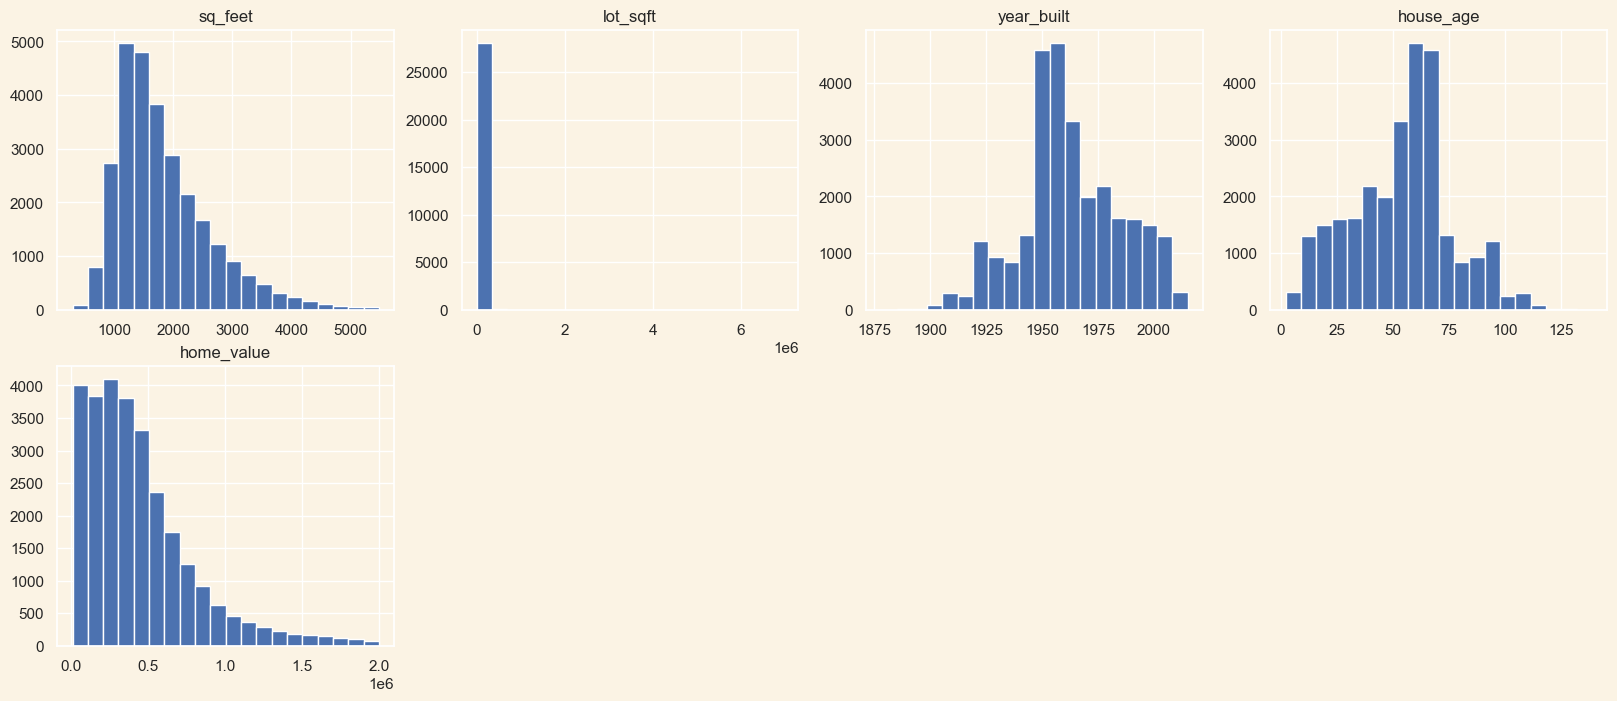

In [52]:
cv = ['sq_feet', 'lot_sqft', 'year_built', 'house_age','home_value']
plt.figure(figsize=(20,8))
for i, col in enumerate(cv):
    #h =  ((i+2) // 4)
    subplot_number = (i+1) 
    plt.subplot(2, 4, subplot_number)
    plt.title(col)
    train[col].hist(bins = 20)

$H_0$: There is no linear correlation between home_value and sq_feet

$H_a$: There is a linear correlation between home_value and sq_feet

In [54]:
# We don't have equal variances and there are outliers in both sq_feet
# and home_values columns. To check if there is a correlation between
# square feet and home price I'll use Spearman's rank correlation test

In [55]:
def sqfeet_test(df):
    '''
    the function accepts a zillow data frame as a parameter
    runs a Spearman's rank correlation test and prints it results
    '''
    corr, p = stats.spearmanr(df.sq_feet, df.home_value)
    if (p < alpha):
        print('We reject the null hypothesis.')
        print('There is a linear correlation between home price and its size(square feet)')
        print(f'The correlation coefficient is {round(corr, 2)}')
    else:
        print('We fail to reject the null hypothesis.')
        print('There is no linear correlation between home price and its size(square feet)')

In [56]:
corr, p = stats.spearmanr(train.sq_feet, train.home_value)

In [57]:
if (p < alpha):
    print('We reject the null hypothesis.')
    print('There is a linear correlation between home price and its size(square feet)')
    print(f'The correlation coefficient is {round(corr, 2)}')
else:
    print('We fail to reject the null hypothesis.')
    print('There is no linear correlation between home price and its size(square feet)')

We reject the null hypothesis.
There is a linear correlation between home price and its size(square feet)
The correlation coefficient is 0.49


In [58]:
train.describe()


,bedrooms,bathrooms,sq_feet,lot_sqft,year_built,house_age,pools,home_value
count,"28,087.000","28,087.000","28,087.000","28,087.000","28,087.000","28,087.000","28,087.000","28,087.000"
mean,3.268,2.158,"1,831.306","10,707.811","1,962.848",54.152,0.202,"442,349.265"
std,0.887,0.860,794.480,"87,180.761",22.634,22.634,0.401,"352,343.397"
min,1.000,1.000,300.000,236.000,"1,878.000",2.000,0.000,"9,242.000"
25%,3.000,2.000,"1,257.000","5,537.500","1,950.000",39.000,0.000,"187,318.000"
50%,3.000,2.000,"1,634.000","6,767.000","1,960.000",57.000,0.000,"361,337.000"
75%,4.000,3.000,"2,225.500","8,537.000","1,978.000",67.000,0.000,"588,844.000"
max,6.000,6.000,"5,477.000","6,971,010.000","2,015.000",139.000,1.000,"1,997,251.000"


## 4. Are the new houses more valuable than the old ones?


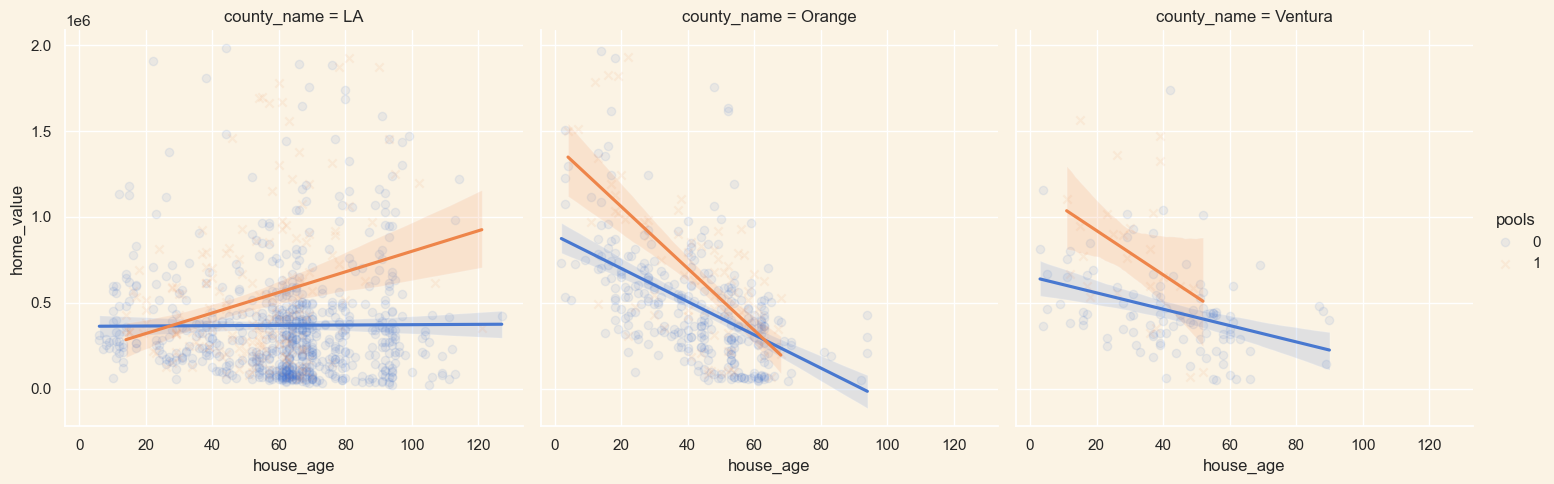

In [59]:
sns.lmplot(x='house_age', y='home_value', data=train.sample(frac=0.05), 
           palette='muted', col='county_name', hue='pools', 
           scatter_kws = {'alpha' : 0.09}, markers=["o", "x"] ); # orange pools, blue no pools

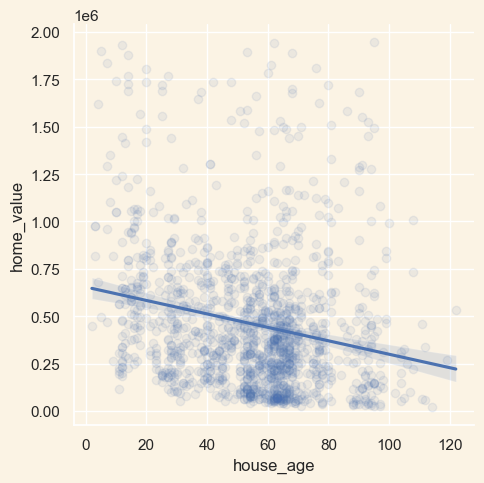

In [60]:
sns.lmplot(x='house_age', y='home_value', data=train.sample(frac=0.05), scatter_kws = {'alpha' : 0.09});


House age correlates differently with price based on the county. If we split the data by county and highlight by the pool availability, we get the posive correlation for houses with pools in LA, almost zero correlation for houses without pools in LA and much stronger negative correlations in other counties.